# Methodology

When evaluating our models' performance, we used the following criteria:
- How well does the model keep the PiCar close to the center of the track?
- How volatile is the angle output during evaluation?
- How big is the model (how many parameters, size of model file)?

To speed up our model evaluation and architecture design, we opted to run tensorflow locally on laptops with dedicated GPUs.

## Data Collection

The data is collected from 3 maps based on the anticipated conditions for our IRL PiCar:

1. A modified default map with windy sections, improving turn variety. 16000 x 2 images.

   ![Track 1, with accentuated turns from the default track.](resources/apsc258-2025-l2c-g7-winding.png)

2. A map with right-angle turns to mimic tape-laid track turns. 8000 x 2 images.

   ![Track 2, with right-angle turns.](resources/apsc258-2025-l2c-g7-rights.png)

3. A map where tracks are placed side by side, and the center line of both are visible to the PiCar simultaneously. This hopefully makes the model more resilient to noise. 8000 x 2 images. Sadly I did not save this track.

For all maps, the car was recorded driving on the track in both directions (clockwise and counter clockwise) to insure uniform coverage of all turning angles, hence two rounds of 8000 images for each track. This wisdom comes from methods in the 2023W2 class, where teams created flipped-duplicates of training images since the turn angles were skewed to right turns. The result is a total of 64000 images.

In [3]:
import zipfile
from pathlib import Path

DATA_ZIP_NAME = 'data.zip'

with zipfile.ZipFile(Path.cwd() / DATA_ZIP_NAME, 'r') as zip_ref:
    zip_ref.extractall()

train_dirs = list(Path.cwd().glob('**/train/'))
test_dirs = list(Path.cwd().glob('**/test/'))

def dataset_file_get_steering_angle(file: Path):
    return float(file.stem.split('_')[1].replace('-', '.'))

steering_angles = []
for folder in train_dirs + test_dirs:
    for file_path in folder.glob('*.png'):
        steering_angles.append(dataset_file_get_steering_angle(file_path))



/tmp/ipykernel_12475/3227076436.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


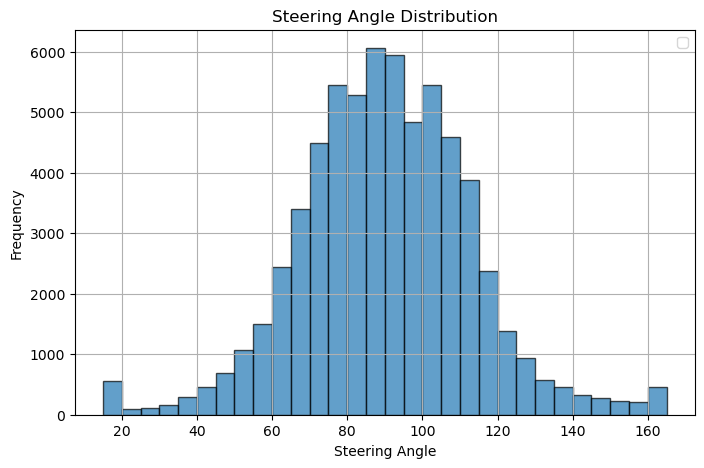

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_steering_angle_distribution(steering_angles):
    plt.figure(figsize=(8, 5))
    plt.hist(steering_angles, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel("Steering Angle")
    plt.ylabel("Frequency")
    plt.title("Steering Angle Distribution")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_steering_angle_distribution(steering_angles)

## Preprocessing

All images go through a color-channel reduction to the green centerline of the tracks. Green pixels are filtered out from the images, creating a grayscale view, and only the center of the track being illuminated.

## Model Designs

The each model architecture for this project was developed through iterative design. Details on their architecture and design choices are described in the next sections.